In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)

suppressMessages(library(dplyr))
library('Matrix')
set.seed(1)

library(RColorBrewer)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(reshape2)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The

In [2]:
#### set enviroment
home = '~/farm/endometrium/data/scATAC/'
setwd(home)
outdir = paste0(home, 'seurat.output-S2/')
system(paste0('mkdir -p ', outdir, '/clusters'))
#### 


In [3]:
### Load data
so = readRDS(file = paste0(outdir, 'data/M3_scRNAseq_labelsTransfer.rds'))

# Construct a Motif object and add it to the dataset

In [4]:
DefaultAssay(so) <- 'peaks'

In [5]:
# Get a list of motif position frequency matrices from the JASPAR, HOCOMOCO, HOMER and SwissRegulon databases
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)
# add data from hocomoco A
tf_motif_hoco=subset(MotifDb, organism=='Hsapiens' & dataSource=='HOCOMOCOv11-core-A')
pfmHoco = convert_motifs(tf_motif_hoco, 'TFBSTools-PWMatrix')
pfmHoco_names =  sapply(pfmHoco, function(x) x@ID)
names(tf_motif_hoco) = pfmHoco_names
for (i in 1:length(pfmHoco) ){
    # Convert into a PCM
    x = t(pfmHoco[[i]]@profileMatrix) - apply(pfmHoco[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHoco[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHoco[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmHoco_names[i]]] <- pfmHoco[[i]]
}
# add data from hocomoco B
tf_motif_hoco=subset(MotifDb, organism=='Hsapiens' & dataSource=='HOCOMOCOv11-core-B')
pfmHoco = convert_motifs(tf_motif_hoco, 'TFBSTools-PWMatrix')
pfmHoco_names =  sapply(pfmHoco, function(x) x@ID)
names(tf_motif_hoco) = pfmHoco_names
for (i in 1:length(pfmHoco) ){
    # Convert into a PCM
    x = t(pfmHoco[[i]]@profileMatrix) - apply(pfmHoco[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHoco[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHoco[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmHoco_names[i]]] <- pfmHoco[[i]]
}
# add data from hocomoco C
tf_motif_hoco=subset(MotifDb, organism=='Hsapiens' & dataSource=='HOCOMOCOv11-core-C')
pfmHoco = convert_motifs(tf_motif_hoco, 'TFBSTools-PWMatrix')
pfmHoco_names =  sapply(pfmHoco, function(x) x@ID)
names(tf_motif_hoco) = pfmHoco_names
for (i in 1:length(pfmHoco) ){
    # Convert into a PCM
    x = t(pfmHoco[[i]]@profileMatrix) - apply(pfmHoco[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHoco[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHoco[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmHoco_names[i]]] <- pfmHoco[[i]]
}
# add data from SwissRegulon                       
tf_motif_SwissRegulon=subset(MotifDb, organism=='Hsapiens' & dataSource=='SwissRegulon')
pfmSwissRegulon = convert_motifs(tf_motif_SwissRegulon, 'TFBSTools-PWMatrix')
pfmSwissRegulon_names =  sapply(pfmSwissRegulon, function(x) x@ID)
names(tf_motif_SwissRegulon) = pfmSwissRegulon_names
for (i in 1:length(pfmSwissRegulon) ){
    # Convert into a PCM
    x = t(pfmSwissRegulon[[i]]@profileMatrix) - apply(pfmSwissRegulon[[i]]@profileMatrix, 2, min) # normalize per column
    pfmSwissRegulon[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmSwissRegulon[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmSwissRegulon_names[i]]] <- pfmSwissRegulon[[i]]
}
# add data from HOMER                       
tf_motif_HOMER=subset(MotifDb, dataSource=='HOMER')
pfmHOMER = convert_motifs(tf_motif_HOMER, 'TFBSTools-PWMatrix')
pfmHOMER_names =  sapply(pfmHOMER, function(x) x@ID)
names(pfmHOMER) = paste0( sapply( strsplit(pfmHOMER_names, '\\('), head, 1), '.HOMER')
pfmHOMER = pfmHOMER[ grep('[a-z]',  names(pfmHOMER), invert = T) ] # remove non-human (lowercase)         
for (i in 1:length(pfmHOMER) ){
    # Convert into a PCM
    x = t(pfmHOMER[[i]]@profileMatrix) - apply(pfmHOMER[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHOMER[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHOMER[[i]]@profileMatrix) <- 'integer'
    pfmHOMER[[i]]@name = gsub('.HOMER', '', names(pfmHOMER)[i])
    pfm[[names(pfmHOMER)[i]]] <- pfmHOMER[[i]]
}

In [6]:
# Add name in id
idx =  grep('^MA', names(pfm) )
for (i in idx ){
    pfm[[i]]@ID = paste0(pfm[[i]]@name, '.', pfm[[i]]@ID)
    names(pfm)[i] = pfm[[i]]@ID
    }

In [7]:
# remove pcm with NAs
pfm = pfm[ ! sapply(pfm, function(x) any(is.na(x@profileMatrix))) ]

In [8]:
length(pfm)
table(unlist(sapply(pfm, function(x) x@tags$dataSource)))

[1] 1681


HOCOMOCOv11-core-A HOCOMOCOv11-core-B HOCOMOCOv11-core-C              HOMER 
               181                 84                135                146 
      SwissRegulon 
               683 

In [9]:
# Scan the DNA sequence of each peak for the presence of each motif
motif.matrix <- CreateMotifMatrix(
  features = StringToGRanges(rownames(so), sep = c(":", "-")),
  pwm = pfm,
  genome = 'hg38',
  sep = c(":", "-")
)
# Create a new Mofif object to store the results
motif <- CreateMotifObject(
  data = motif.matrix,
  pwm = pfm
)
# Add the Motif object to the assay
so[['peaks']] <- AddMotifObject(
  object = so[['peaks']],
  motif.object = motif
)

In [10]:
# Compute  sequence characteristics of the peaks: GC content, sequence length, and dinucleotide frequency
so <- RegionStats(
  object = so,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  sep = c(":", "-")
)

# Finding active TFmotifs - ChromVAR

This tends to give similar results as performing an enrichment test on differentially accessible peaks between the cell types

In [11]:
so <- RunChromVAR(
  object = so,
  genome = BSgenome.Hsapiens.UCSC.hg38
)

Computing GC bias per region

Selecting background regions

Computing motif deviations from background

Constructing chromVAR assay

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have pipe characters ('|'), replacing with dashes ('-')"


In [12]:
saveRDS(so,  paste0(outdir, '/data/M4_TFmotif_activities.rds'))

In [13]:
# so = readRDS(paste0(outdir, '/data/M4_TFmotif_activities.rds'))

In [14]:
motif2names = lapply(pfm, function(x) x@name)
names(motif2names) = sapply(pfm, function(x) x@ID) %>% gsub('_', '-', .)

In [15]:
DefaultAssay(so) <- 'chromvar'
for( cl in levels(Idents(so)) ){
  message('Testing ', cl,'\n')
  differential.activity = FindMarkers(so, ident.1 = cl, test.use = "LR", only.pos = TRUE, latent.vars = 'nCount_peaks', 
                                      logfc.threshold = 0.1, min.pct = 0.1)
  differential.activity$TF = motif2names[ rownames(differential.activity) ] %>% as.character(.)
  write.csv(differential.activity, file = paste0(outdir, '/clusters/', cl, '_differential.activity_LR.csv'))
}

Testing proliferative


Testing KRT5_LRG6


Testing KRT5_KRT13


Testing inter


Testing inter_PGRpos


Testing inter_PGRneg


Testing pre_new_secretory


Testing new_secretory


Testing glandular_secretory


Testing pre-ciliated


Testing ciliated




# Compare Ciliated and new secretory vs PGR+

In [16]:
retrieve_top10 = function(differential.activity, n = 10, name = F){
    # Fix homer names
  idx = grep('HOMER', differential.activity$X)
  differential.activity$TF[ idx ] = gsub('.HOMER', '', differential.activity$X[ idx ])
  # Fix hocomoco synonyms
  differential.activity$TF2 = differential.activity$TF
  idx = differential.activity$TF %in% syn2gen$V1
  differential.activity$TF2[ idx ] =  syn2gen$V2[ match(differential.activity$TF[ idx ], syn2gen$V1) ] 
  differential.activity = differential.activity[ ! duplicated(differential.activity$TF2) , ]
  differential.activity = subset(differential.activity, avg_logFC > 0.5)
  differential.activity = subset(differential.activity, p_val_adj < 0.01)
    
  tfs = head(differential.activity$X, n = n) 
  if(name)
    tfs = head(differential.activity$TF2, n = n) 
  return(tfs)
}

In [19]:
# Load synonyms to annorate Tfs to their symbol
syn2gen = read.delim('~/secondary2primary_genename.annot', stringsAsFactors = F, header = F)
syn2gen = syn2gen[ order(syn2gen$V1 == syn2gen$V2, decreasing = T) , ]
syn2gen = syn2gen[ ! duplicated(syn2gen$V1) , ] # remove secondaries with several synonyms ( different from the primary )

In [20]:
DefaultAssay(so) <- 'chromvar'
TOP10 = list()
All = list()

# PGR
differential.activity = FindMarkers(so, 
                                    ident.1 = c('inter_PGRpos'), ident.2 = c('new_secretory', 'ciliated'), 
                                    test.use = "LR", only.pos = TRUE, latent.vars = 'nCount_peaks', 
                                    logfc.threshold = 0.1, min.pct = 0.1)
differential.activity$TF = motif2names[ rownames(differential.activity) ] %>% as.character(.)
differential.activity$X = rownames(differential.activity)
write.csv(differential.activity, file = paste0(outdir, '/clusters/PGR_vs_other_differential.activity_LR.csv'))
TOP10[['PGR']] = retrieve_top10(differential.activity)
All[['PGR']] = retrieve_top10(differential.activity, n = 20000, name = T)

# ciliated
differential.activity = FindMarkers(so, 
                                    ident.1 = 'ciliated', ident.2 = c('inter_PGRpos', 'new_secretory'), 
                                    test.use = "LR", only.pos = TRUE, latent.vars = 'nCount_peaks', 
                                    logfc.threshold = 0.1, min.pct = 0.1)
differential.activity$TF = motif2names[ rownames(differential.activity) ] %>% as.character(.)
differential.activity$X = rownames(differential.activity)
write.csv(differential.activity, file = paste0(outdir, '/clusters/ciliated_vs_other_differential.activity_LR.csv'))
TOP10[['ciliated']] = retrieve_top10(differential.activity)
All[['ciliated']] = retrieve_top10(differential.activity, n = 20000, name = T)

# new_secretory
differential.activity = FindMarkers(so, 
                                    ident.1 = 'new_secretory', ident.2 = c('inter_PGRpos', 'ciliated'), 
                                    test.use = "LR", only.pos = TRUE, latent.vars = 'nCount_peaks', 
                                    logfc.threshold = 0.1, min.pct = 0.1)
differential.activity$TF = motif2names[ rownames(differential.activity) ] %>% as.character(.)
differential.activity$X = rownames(differential.activity)
write.csv(differential.activity, file = paste0(outdir, '/clusters/newsecretory_vs_other_differential.activity_LR.csv'))
TOP10[['new_secretory']] = retrieve_top10(differential.activity)
All[['new_secretory']] = retrieve_top10(differential.activity, n = 20000, name = T)

In [21]:
soF = subset(so, cells = names(Idents(so))[ Idents(so) %in% c('inter_PGRpos', 'ciliated', 'new_secretory') ] )

In [33]:
Idents(soF) = factor(Idents(soF), levels =  rev(c('inter_PGRpos', 'ciliated', 'new_secretory')))

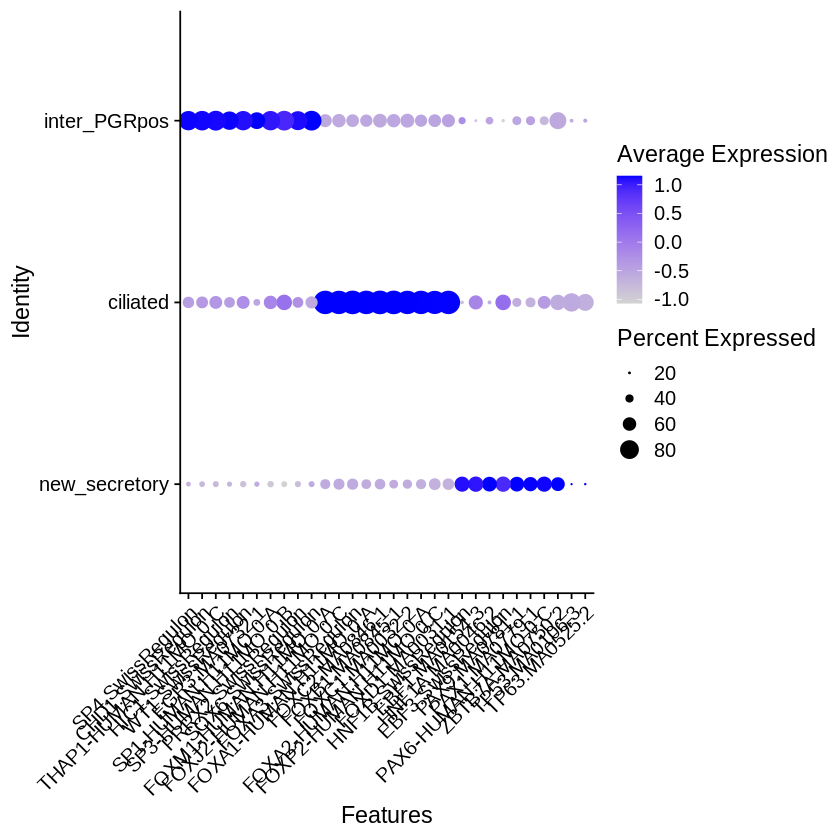

In [55]:
# DoHeatmap(soF, features = unlist(TOP10), slot = 'data') + scale_fill_gradientn(colors = c("grey", "red"), )
# ggsave(device = 'pdf', file = paste0(outdir, '/clusters/heatmap_TFmotifs_invivo.pdf'), width = 12, height = 10)
DotPlot(object = soF, features = rev(unlist(TOP10))) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))
ggsave(device = 'pdf', file = paste0(outdir, '/clusters/dotplot_TFmotifs_invivo.pdf'), width = 12, height = 5)

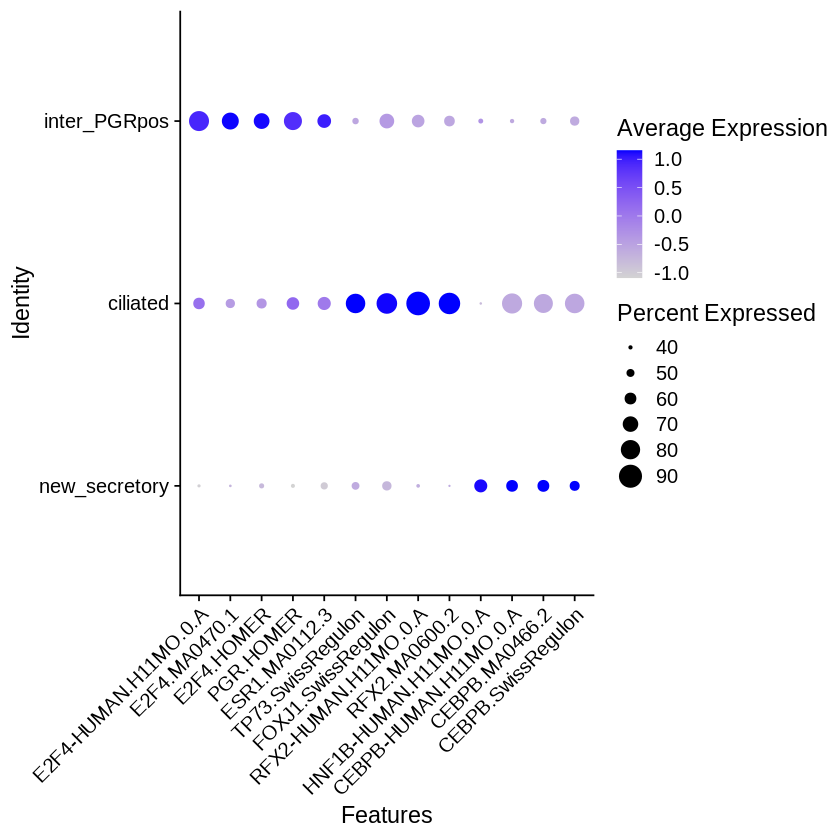

In [51]:
TFmotifs = c('E2F4-HUMAN.H11MO.0.A', "E2F4.MA0470.1", "E2F4.HOMER", 'PGR.HOMER','ESR1.MA0112.3', 
            'TP73.SwissRegulon', 'FOXJ1.SwissRegulon', "RFX2-HUMAN.H11MO.0.A", 'RFX2.MA0600.2', 
            'HNF1B-HUMAN.H11MO.0.A', 'CEBPB-HUMAN.H11MO.0.A', "CEBPB.MA0466.2", "CEBPB.SwissRegulon")
# DoHeatmap(soF, features = TFmotifs, slot = 'data') + scale_fill_gradientn(colors = c("white", "red"), )
# ggsave(device = 'pdf', file = paste0(outdir, '/clusters/heatmap_TFmotifs_invivo_intersectRNA.pdf'), width = 12, height = 10)
DotPlot(object = soF, features = rev(TFmotifs)) + 
# theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) + 
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))
ggsave(device = 'pdf', file = paste0(outdir, '/clusters/dotplot_TFmotifs_invivo_intersectRNA.pdf'), width = 7, height = 5.2)

## Plot top TF motifs

In [56]:
DefaultAssay(so) <- 'chromvar'
TOP5 = list()
All = list()
for( cl in rev(levels(Idents(so))) ){
  message('Testing ', cl,'\n')
  differential.activity = read.csv(file = paste0(outdir, '/clusters/', cl, '_differential.activity_LR.csv'), stringsAsFactors = F)
  # Fix homer names
  idx = grep('HOMER', differential.activity$X)
  differential.activity$TF[ idx ] = gsub('.HOMER', '', differential.activity$X[ idx ])
  # Fix hocomoco synonyms
  differential.activity$TF2 = differential.activity$TF
  idx = differential.activity$TF %in% syn2gen$V1
  differential.activity$TF2[ idx ] =  syn2gen$V2[ match(differential.activity$TF[ idx ], syn2gen$V1) ] 
  differential.activity = differential.activity[ ! duplicated(differential.activity$TF2) , ]
    
  TOP5[[cl]] = head(differential.activity$X, n = 6) 
  All[[cl]] = subset(differential.activity, avg_logFC > 1 & p_val_adj < 0.01 )$TF2
  if( length(TOP5[[cl]]) > 1 )
      for ( tf in TOP5[[cl]] ) {
          # Get MotifPlot
          p2 = MotifPlot(
            object = so,
            motifs = gsub('-', '_', tf),
            assay = 'peaks'
          )
          p1 = FeaturePlot(
            object = so,
            features = tf,
            pt.size = 0.1,
            cols = c("grey", "red"), min.cutoff = 0.5)
          P = plot_grid(plotlist = list(p1, p2), ncol = 1)
          save_plot(plot = P, filename = paste0(outdir, '/clusters/', cl, '_differential.activity_motifPlot_',tf,'.pdf'), base_width = 4, base_height = 7)
       }
}

All = lapply(All, unique)
duplicatedTFs = unlist( All)[ duplicated(unlist( All)) ]
All_clusters_specific = lapply(All, setdiff, duplicatedTFs )
All_clusters_specific

Testing ciliated


Testing pre-ciliated


Testing glandular_secretory


Testing new_secretory


Testing pre_new_secretory


Testing inter_PGRneg


Testing inter_PGRpos


Testing inter


Testing KRT5_KRT13


Testing KRT5_LRG6


Testing proliferative




$ciliated
  [1] "FOXJ2"       "FOXA3"       "FOXA1"       "FOXC2"       "FOXA2"      
  [6] "FOXB1"       "FOXC1"       "FOXF1"       "FOXP1"       "FOXD1"      
 [11] "FOXI1"       "FOXL1"       "FOXO4"       "FOXK1"       "FOXK2"      
 [16] "FOXO1"       "RFX"         "RFX2"        "FOXF2"       "RFX3"       
 [21] "FOXD3"       "RFX7"        "FOXH1"       "RFX5"        "FOXQ1"      
 [26] "RFX4"        "ONECUT2"     "BRCA1"       "SNAI2"       "MESP1"      
 [31] "ZKSC1"       "TCF4"        "NR4A3"       "FIGLA"       "PPARA"      
 [36] "ZIC1"        "ZIC4"        "MSC"         "TFAP4"       "MYB"        
 [41] "TCF3"        "NR2F2"       "FOXJ1"       "NR4A2"       "COUP-TFII"  
 [46] "GLI1"        "ID4"         "MYBL1"       "NKX2-2"      "TWIST1"     
 [51] "NFIB"        "ASCL1"       "MYOD1"       "HNF4A"       "NEUROD1"    
 [56] "NDF1"        "ANDR"        "MYOG"        "ESRRB"       "NFY"        
 [61] "SCRT2"       "NR5A2"       "EBNA1"       "REST"        "OCT:OCT"    
 [66] "ZN335"       "NR2C2"       "PO2F1"       "GTF2I"       "ARID5B"     
 [71] "ZNF423"      "SMAD1"       "ERR2"        "NR2C1"       "RXR"        
 [76] "NHLH1"       "STAT3"       "HMX3"        "POU5F1"      "ZNF16"      
 [81] "OSR2"        "ZN449"       "NR1H2::RXRA" "PTF1A"       "ATOH1"      
 [86] "RORA"        "ZNF415"      "NR1H3"       "RARA(var.2)" "SOX8"       
 [91] "CSTA"        "SF1"         "ZN563"       "MAF"         "RXRG"       
 [96] "ZN250"       "TLX1"        "HIC2"        "ZKSCAN1"     "ETS:RUNX"   
[101] "TAL1::TCF3"  "NKX21"       "HMX2"        "ASCL2"       "PPARE"      
[106] "RARA::RXRG"  "ZBTB6"       "ZBTB18"      "ZN768"       "KRT7"       
[111] "NKX6-2"      "GCM1"        "NF1:FOXA1"   "RARA"        "OLIG3"      
[116] "ZN418"       "CUX1"        "BHLHA15"     "ZFP3"        "ZSC22"      
[121] "ZBT18"       "STAT5A"      "MNT"         "NR1I3"       "ZN257"      
[126] "CTCF"        "BCL6"        "ZN490"       "SOX7"        "TCF7"       
[131] "ZN547"       "WRNIP1"      "PAX8"        "RAD21"       "ZNF24"      
[136] "BACH2"       "SMC3"        "ISRE"        "BATF::JUN"   "FOSB"       
[141] "JDP2"        "FOSL1::JUND" "JUN::JUNB"   "FOSL2::JUND" "FOSL2::JUN" 
[146] "FOSL1::JUN"  "FOSL1::JUNB" "FOS::JUND"   "FOS::JUN"    "FOSL1"      

$`pre-ciliated`
character(0)

$glandular_secretory
[1] "TEAD3"              "TEAD1"              "TEAD"              
[4] "AP-1"               "FOSL2::JUNB(var.2)"

$new_secretory
 [1] "CEBPD"    "CEBPE"    "HNF1B"    "CEBPA"    "CEBPB"    "PAX9"    
 [7] "HNF1A"    "PAX1"     "EBF3"     "CEBP:AP1" "ZBTB7A"  

$pre_new_secretory
character(0)

$inter_PGRneg
 [1] "PITX3"  "GSC"    "GSC2"   "ESX1"   "OTX2"   "PHOX2A" "SHOX"   "CRX"   
 [9] "ISX"    "LHX9"   "PRRX1"  "RAX2"   "BSX"    "PROP1"  "GSX1"  

$inter_PGRpos
 [1] "SOX17"              "SOX6"               "SOX3"              
 [4] "SOX15"              "PRDM6"              "SOX5"              
 [7] "DMRT1"              "SOX13"              "ZN394"             
[10] "NFAT:AP1"           "SOX12"              "HOXD11"            
[13] "NFKB1"              "NFATC2"             "ZBTB16"            
[16] "RELA"               "FEZF1"              "SOX18"             
[19] "TCF7L1"             "NFATC3"             "HIVEP1"            
[22] "RELB"               "ETV5"               "AIRE"              
[25] "NFKB2"              "SUH"                "TF65"              
[28] "RBPJ"               "DLX2"               "NKX6-1"            
[31] "EN2"                "VAX1"               "VAX2"              
[34] "FOSL2::JUND(var.2)" "ATF2"               "HOXA2"             
[37] "JUNB"               "JUND(var.2)"       

$inter
 [1] "COT1"       "ZNF281"     "SIN3A"      "SRBP2"      "PLAG1"     
 [6] "TBX3"       "HOXB5"      "INSM1"      "ZN436"      "PLAGL1"    
[11] "AP2C"       "RARA::RXRA" "ZNF322"     "GLI3"       "ZN322"     
[16] "ZN708"     

$KRT5_KRT13
 [1] "MITF"          "USF1"          "PBX3"          "GRHL2"        
 [5] "ETV

In [26]:
# DoHeatmap(so, features = unlist(TOP5), slot = 'data') + scale_fill_gradientn(colors = c("grey", "red"))
# ggsave(device = 'pdf', file = paste0(outdir, '/general/heatmap_TFmotifs.pdf'), width = 12, height = 10)

In [58]:
TF2plot = list('inter_PGRpos' = c('E2F4-HUMAN.H11MO.0.A', "E2F4.MA0470.1", "E2F4.HOMER", 'PGR.HOMER','ESR1.MA0112.3'), 
             'ciliated' = c('TP73.SwissRegulon', 'FOXJ1.SwissRegulon', "RFX2-HUMAN.H11MO.0.A", 'RFX2.MA0600.2'), 
             'new_secretory' = c('HNF1B-HUMAN.H11MO.0.A', 'CEBPB-HUMAN.H11MO.0.A', "CEBPB.MA0466.2", "CEBPB.SwissRegulon"))


for( cl in names(TF2plot) ){
  message('Testing ', cl,'\n')
  differential.activity = read.csv(file = paste0(outdir, '/clusters/', cl, '_differential.activity_LR.csv'), stringsAsFactors = F)
  rownames(differential.activity) = differential.activity$X
  for ( tf in TF2plot[[cl]]) {
      # Get MotifPlot
      p2 = MotifPlot(
        object = so,
        motifs = gsub('-', '_', tf),
        assay = 'peaks'
      )
      p1 = FeaturePlot(
        object = so,
        features = tf,
        pt.size = 0.2,
        cols = c("grey", "red"), min.cutoff = 0.5)
      P = plot_grid(plotlist = list(p1, p2), ncol = 1)
     save_plot(plot = P, filename = paste0(outdir, '/clusters/', cl, '_differential.activity_motifPlot_',tf,'.pdf'), base_width = 4, base_height = 7)
   }
}

Testing inter_PGRpos


Testing ciliated


Testing new_secretory




# Finding overrepresented TF motifs in DARs

Search for DNA motifs that are overrepresented in a set of peaks that are differentially accessible between cell clusters
that we previously computed

In [23]:
# THERE IS a BUG IN THIS CODE WHEN ADDING MOTIFS APPART from JASPAR
# DefaultAssay(so) <- 'peaks'
# for( cl in rev(levels(Idents(so))) ){
#   cat('Loading ', cl,' DARs\n')
#   da_peaks2 = read.csv(file = paste0(outdir, '/clusters/DARs/', cl, '_LR.csv'), stringsAsFactors = F)
#   da_peaks2 = subset(da_peaks2, avg_logFC > 0 & p_val < 0.0001 )
#   rownames(da_peaks2) = da_peaks2$X
#   enriched.motifs <- FindMotifs(object = so,
#     features = rownames(da_peaks2)
#   )
# #   enriched.motifs = enriched.motifs[ order(enriched.motifs$pvalue, decreasing = F) ,]
#   enriched.motifs$cluster = cl
# #   # patch 
# #   enriched.motifs$true_pvalue =   as.numeric(enriched.motifs[ 1 , grep('^pvalue', names(enriched.motifs)) ])
# #   enriched.motifs = enriched.motifs[  , - grep('^pvalue', names(enriched.motifs)) ]
# #   enriched.motifs = enriched.motifs[order(enriched.motifs$true_pvalue, decreasing = F), ]
#   write.csv(enriched.motifs, file = paste0(outdir, '/clusters/DARs/', cl, '_enrichedTFmotifs.csv'))
# }

In [2]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/jovyan/my-conda-envs/R4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] reshape2_1.4.4                    cowplot_1.0.0                    
 [3] pheatmap_1.0.12                   ggplot2_3.3.1                    
 [5] RColorBrewer_1.1-2                Matrix_1.2-18                    
 [7] dplyr_1.0.0                       MotifDb_1.30.0          